In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict


import tensorflow as tf
import os
import cv2
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras import utils
from tensorflow.keras import datasets
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8

In [2]:
train_path = '/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/train_images_resized'
test_path = '/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/test_images_resized'

df = pd.read_csv('/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/train.csv')
df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [3]:
df.shape

(18632, 2)

In [4]:
dct = defaultdict(list)

for i, label in enumerate(df.labels):
    for category in label.split():
        dct[category].append(i)

dct = {key: np.array(val) for key, val in dct.items()}
dct

{'healthy': array([    0,     5,     7, ..., 18626, 18627, 18631]),
 'scab': array([    1,     2,     3, ..., 18625, 18628, 18630]),
 'frog_eye_leaf_spot': array([    1,    14,    31, ..., 18612, 18619, 18630]),
 'complex': array([    1,     4,     8, ..., 18597, 18604, 18617]),
 'rust': array([    6,    21,    26, ..., 18601, 18616, 18629]),
 'powdery_mildew': array([   20,    39,    44, ..., 18532, 18617, 18618])}

In [5]:
new_df = pd.DataFrame(np.zeros((df.shape[0], len(dct.keys())), dtype = np.int8), columns = dct.keys())

for key, val in dct.items():
    new_df.loc[val, key] = 1

new_df.head()

,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,1,0,0,0,0,0
1,0,1,1,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0


In [6]:
new_df.sum(axis = 0)

healthy               4624
scab                  5712
frog_eye_leaf_spot    4352
complex               2151
rust                  2077
powdery_mildew        1271
dtype: int64

In [7]:
cats_total = new_df.sum(axis = 1).values

np.sort(cats_total)


array([1, 1, 1, ..., 3, 3, 3])

In [8]:
np.mean(cats_total)

1.083458565908115

In [9]:
from collections import Counter

Counter(df.labels)

Counter({'healthy': 4624,
         'scab frog_eye_leaf_spot complex': 200,
         'scab': 4826,
         'complex': 1602,
         'rust': 1860,
         'frog_eye_leaf_spot': 3181,
         'powdery_mildew': 1184,
         'scab frog_eye_leaf_spot': 686,
         'frog_eye_leaf_spot complex': 165,
         'rust frog_eye_leaf_spot': 120,
         'powdery_mildew complex': 87,
         'rust complex': 97})

In [10]:
ks = {k: i for i,k in enumerate(Counter(df.labels).keys())}
new_df['labs'] = np.array([ks[v] for v in df.labels])
new_df['labs']

0        0
1        1
2        2
3        2
4        3
        ..
18627    0
18628    2
18629    4
18630    7
18631    0
Name: labs, Length: 18632, dtype: int64

In [11]:
new_df = pd.concat([df, new_df], axis = 1)

new_df.head()

,image,labels,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew,labs
0,800113bb65efe69e.jpg,healthy,1,0,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,0,1,1,1,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,0,1,0,0,0,0,2
3,80077517781fb94f.jpg,scab,0,1,0,0,0,0,2
4,800cbf0ff87721f8.jpg,complex,0,0,0,1,0,0,3


In [12]:
new_df.to_csv('/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/better_train.csv', index = False)

In [13]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras import utils
from tensorflow.keras import datasets
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.resnet50 import ResNet50

In [14]:
target_columns = list(new_df.columns[2:-1])

target_columns

['healthy', 'scab', 'frog_eye_leaf_spot', 'complex', 'rust', 'powdery_mildew']

In [15]:
def extend_network(base_model, number_of_class):
    # don't train existing weights of Convolution Layers
    for layer in base_model.layers:
        layer.trainable = False

    # prediction layers
    gap = layers.GlobalAveragePooling2D()
    fc_1 = layers.Dense(number_of_class, activation='softmax', name='predictions')

    # create new model object
    new_model = models.Sequential(name="new_model")

    # add prediction layers to new model object
    new_model.add(base_model)
    new_model.add(gap)
    new_model.add(fc_1)

    # define optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)

    # compile new model
    new_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return new_model

In [16]:
def plot_graphs(res):
    # loss
    plt.plot(res.history['loss'], label='train loss')
    plt.plot(res.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

    # accuracies
    plt.plot(res.history['accuracy'], label='train acc')
    plt.plot(res.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

In [17]:
network_size = (224,224)
number_of_classes = 6

In [18]:
# with include_top = False, you can pull just CNNs not FC layers. We use ResNet50 as backbone
base_model = ResNet50(weights="imagenet", include_top=False, input_shape = (224, 224, 3))

In [19]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
# extend the network with FC layers
new_model = extend_network(base_model=base_model, number_of_class=number_of_classes)
new_model.summary()

Model: "new_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
batch_size = 64
image_generator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    
    rotation_range=30, 
    zoom_range=0.15,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    vertical_flip=False,
    fill_mode="reflect"#,
    #validation_split = 0.3
  )



new_df = new_df.iloc[np.random.choice(new_df.shape[0], new_df.shape[0], replace = False),:]

skf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 1488)

train_ind, test_ind = next(skf.split(new_df, new_df['labs']))

train_generator = image_generator.flow_from_dataframe(
    dataframe = new_df.iloc[train_ind,:],
    directory = train_path,
    x_col="image",
    y_col = target_columns,
    weight_col=None,
    target_size = network_size,
    color_mode="rgb",

    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=None,

    #subset='training',
    interpolation="box"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe = new_df.iloc[test_ind,:],
    directory = train_path,
    x_col="image",
    y_col = target_columns,
    weight_col=None,
    target_size = network_size,
    color_mode="rgb",

    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=None,

    #subset='validation',
    interpolation="box"
)

Found 16303 validated image filenames.
Found 2329 validated image filenames.


In [22]:
batch = next(validation_generator)

print(batch[1].shape)

(64, 6)


In [23]:
train_ind

array([    0,     1,     2, ..., 18627, 18629, 18630])

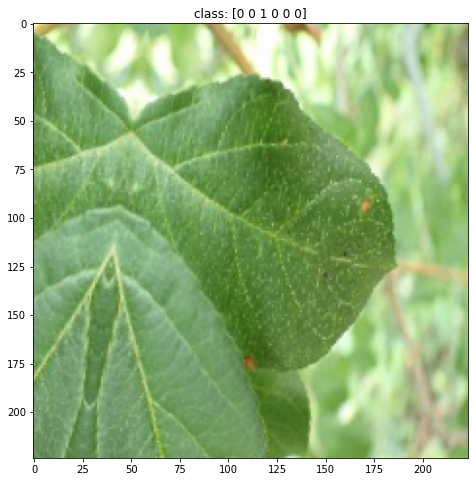

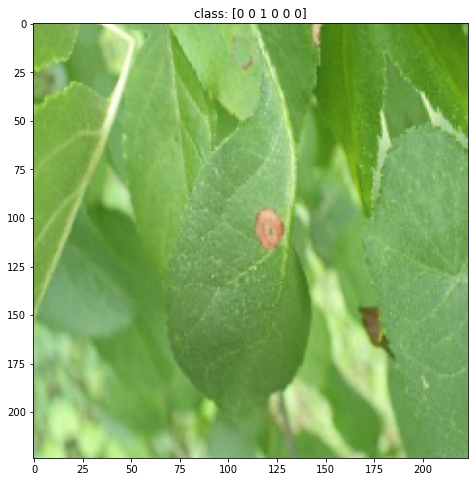

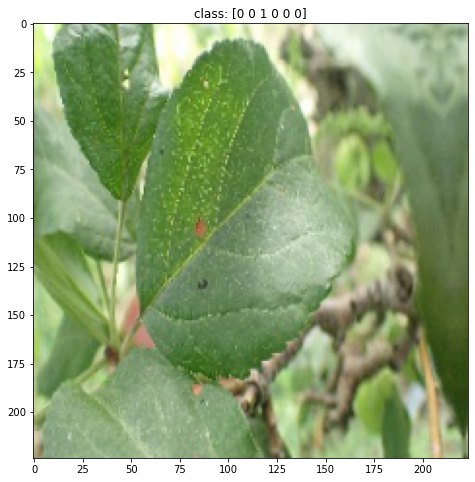

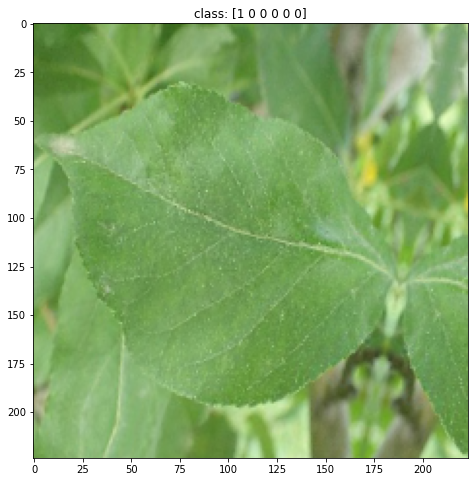

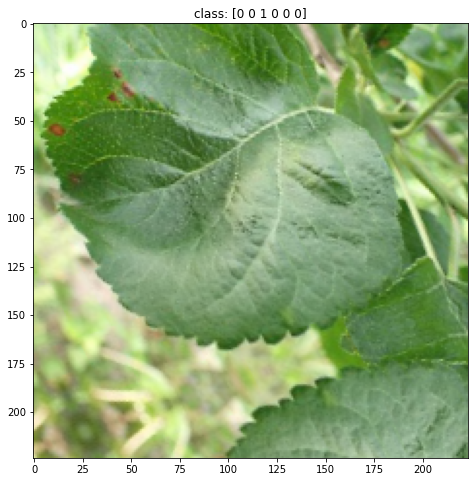

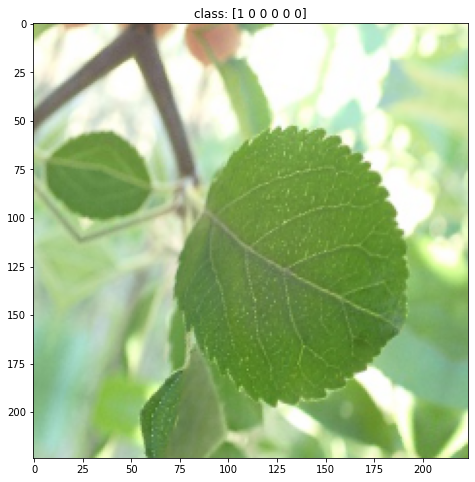

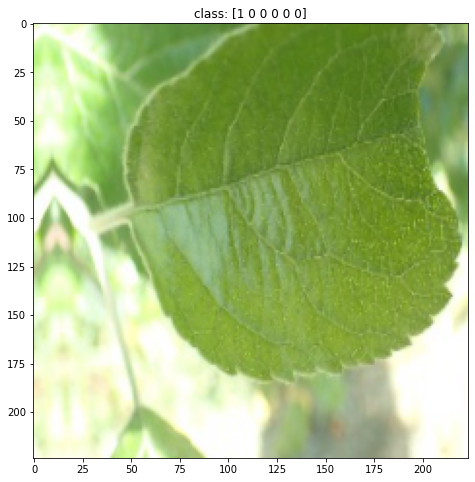

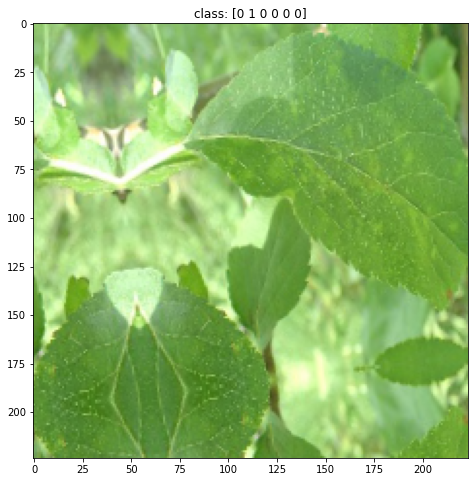

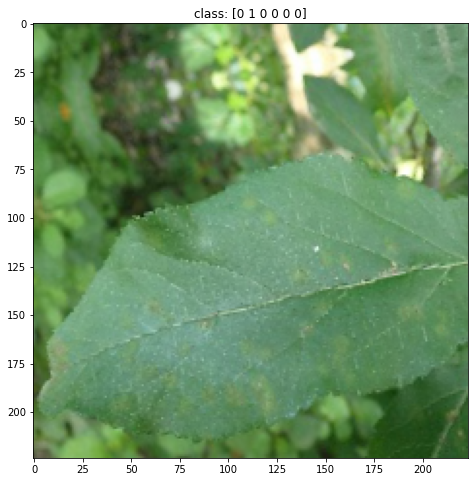

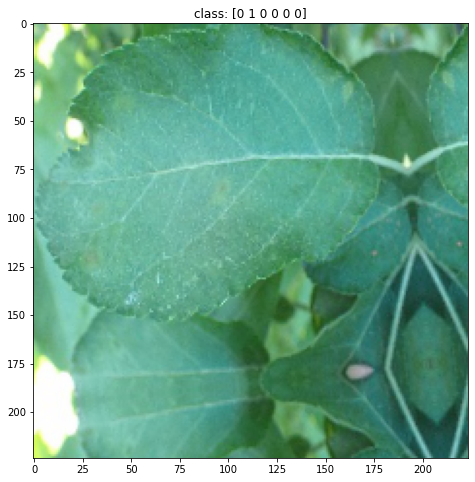

In [24]:


for i in range(10):
    plt.imshow(batch[0][i,:,:,:])
    cl = batch[1][i]
    plt.title(f'class: {cl}')
    plt.show()



In [25]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# if val_accuracy value does not increase for four epochs, then stop the training
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=7, verbose=0, mode='max')

# save best model only
mcp_save = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, 
                           monitor='val_accuracy', mode='max')
# train the network
res = new_model.fit_generator(
        generator=train_generator,
        validation_data=validation_generator,
        epochs=1,
        callbacks=[earlyStopping, mcp_save]
    )

255/255 [==============================] - 179s 701ms/step - loss: 0.3023 - accuracy: 0.8743 - val_loss: 0.6263 - val_accuracy: 0.7930


In [26]:
os.listdir(checkpoint_dir)


['checkpoint',
 'cp.ckpt.index',
 'cp.ckpt.data-00001-of-00002',
 'cp.ckpt.data-00000-of-00002']

In [27]:
# Create a basic model instance
loaded_model = extend_network(base_model=base_model, number_of_class=number_of_classes)
loaded_model.load_weights(checkpoint_path)



In [28]:
test_df = pd.read_csv('/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/sample_submission.csv')


test_generator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255
)


test_generator = test_generator.flow_from_dataframe(
    dataframe= test_df,
    directory = test_path,
    x_col = "image",
    y_col = 'labels',
    target_size = network_size,
    color_mode="rgb",

    batch_size=1,
    shuffle=False,
    seed=None,

    subset=None,
    
    interpolation="box"
)



Found 3 validated image filenames belonging to 1 classes.


In [29]:
answer = new_model.predict(test_generator)
answer

array([[0.49586925, 0.06582384, 0.0072075 , 0.06364467, 0.14130011,
        0.22615464],
       [0.5074774 , 0.05428986, 0.01019837, 0.06166534, 0.14050192,
        0.22586714],
       [0.50185984, 0.0566292 , 0.00998322, 0.06168355, 0.14103042,
        0.22881384]], dtype=float32)

In [30]:
import cv2
def test_single_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    return img

In [31]:
path = "/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/train_images/805fac7a36ea178c.jpg"
img = test_single_img(path)
answer = new_model.predict(img)

In [32]:
answer

array([[0.4688577 , 0.0630324 , 0.01007947, 0.06566036, 0.16130151,
        0.23106852]], dtype=float32)